In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(all_categories)

Slusarski
18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [5]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [6]:
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0,letterToIndex(letter)] = 1
    return tensor

In [7]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for ind,letter in enumerate(line):
        tensor[ind,0,letterToIndex(letter)] = 1
    return tensor

In [62]:
lineToTensor('Gurkirat').size()

torch.Size([8, 1, 57])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cpu')

In [10]:
a = torch.randint(2,(1,))
if a.item==1:
    print('yes')

In [11]:
class SNN1(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.combined_list = []
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.gain = torch.tensor(1,requires_grad=True,dtype=torch.float32)
        self.bias = torch.tensor(0,requires_grad=True,dtype=torch.float32)


    def forward(self,input,hidden,combinedList):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        if len(combinedList)!=0:
            for i in range(1,len(combinedList)):
                hidden += combinedList[i]
        hidden = hidden - torch.mean(hidden,1)
        hidden = hidden / torch.std(hidden,1)
        hidden = self.gain*hidden + self.bias
        combinedList.append(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
        
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

    def initCombined(self):
        return []     
            
            

In [12]:
n_hidden = 128
rnn = SNN1(n_letters,n_hidden,n_categories)

In [13]:
def categoryFromOutput(output):
    max, ind = output.topk(1)
    ind = ind[0].item()
    return all_categories[ind], ind

In [14]:
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingSample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [15]:
for name, param in rnn.named_parameters():
    print(name)

i2h.weight
i2h.bias
i2o.weight
i2o.bias


In [16]:
rnn.gain.retain_grad()
rnn.bias.retain_grad()
parameters = [rnn.i2h.weight,rnn.i2h.bias,rnn.i2o.weight,rnn.i2o.bias,rnn.gain,rnn.bias]

In [17]:
loss_fn = nn.NLLLoss()
optim = torch.optim.SGD(parameters,lr=0.005)

def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    combined = rnn.initCombined()
    y = category_tensor
    x = line_tensor
    for i in range(x.size()[0]):
        output,hidden = rnn(x[i],hidden,combined)
    
    loss = loss_fn(output,y)

    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()

    return output, loss.item()


In [18]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000,5000
epochs = 100000

for i in range(epochs):
    category,line,category_tensor,line_tensor = randomTrainingSample()

    output, loss = train(category_tensor,line_tensor)
    current_loss += loss
    if (i+1)%plot_steps==0:
        all_losses.append(current_loss/plot_steps)
        if (i+1)%print_steps==0:
            print(f'Step {i+1} --> {all_losses[-1]} ')
        current_loss=0


Step 5000 --> 2.3514548372328283 
Step 10000 --> 2.1718135255873205 
Step 15000 --> 1.9601384228467942 
Step 20000 --> 1.9421811355948448 
Step 25000 --> 1.808181869082153 
Step 30000 --> 1.739178441233933 
Step 35000 --> 1.6875812865160407 
Step 40000 --> 1.5686321362573654 
Step 45000 --> 1.5598359755165876 
Step 50000 --> 1.5403714006431402 
Step 55000 --> 1.4797996956473216 
Step 60000 --> 1.4477420046441256 
Step 65000 --> 1.4683814051216468 
Step 70000 --> 1.3575930818123743 
Step 75000 --> 1.3786277328543366 
Step 80000 --> 1.3773131319824605 
Step 85000 --> 1.3568066746648402 
Step 90000 --> 1.3977363807684742 
Step 95000 --> 1.354790619232226 
Step 100000 --> 1.3342391485786065 


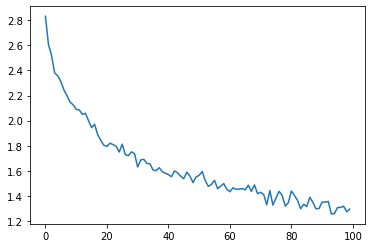

In [333]:
plt.plot(all_losses)

In [32]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    combined = rnn.initCombined()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden,combined)

    return output

In [65]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kamboj')
predict('Reigns')
predict('Hamilton')


> Kamboj
(-1.42) Polish
(-1.68) Arabic
(-2.05) Czech

> Reigns
(-1.33) Dutch
(-1.92) English
(-2.16) Irish

> Hamilton
(-1.45) English
(-1.50) Scottish
(-1.57) Russian
